In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

# Загрузка данных
url = "https://raw.githubusercontent.com/Arhangel333/ML/main/datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv"
       ##https://github.com/Arhangel333/ML/blob/main/datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv
df = pd.read_csv(url)

In [5]:
print("=== ОСНОВНАЯ ИНФОРМАЦИЯ О ДАННЫХ ===")
print(f"Размер датасета: {df.shape}")
print("\nПервые 5 строк:")
print(df.head())

print("\n=== ИНФОРМАЦИЯ О СТОЛБЦАХ ===")
print(df.info())

print("\n=== СТАТИСТИЧЕСКОЕ ОПИСАНИЕ ===")
print(df.describe())

print("\n=== ПРОПУЩЕННЫЕ ЗНАЧЕНИЯ ===")
print(df.isnull().sum())

print("\n=== УНИКАЛЬНЫЕ ЗНАЧЕНИЯ В КАТЕГОРИАЛЬНЫХ ПРИЗНАКАХ ===")
categorical_columns = df.select_dtypes(include=['object']).columns
for col in categorical_columns:
    print(f"{col}: {df[col].unique()}")

=== ОСНОВНАЯ ИНФОРМАЦИЯ О ДАННЫХ ===
Размер датасета: (7043, 21)

Первые 5 строк:
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...  

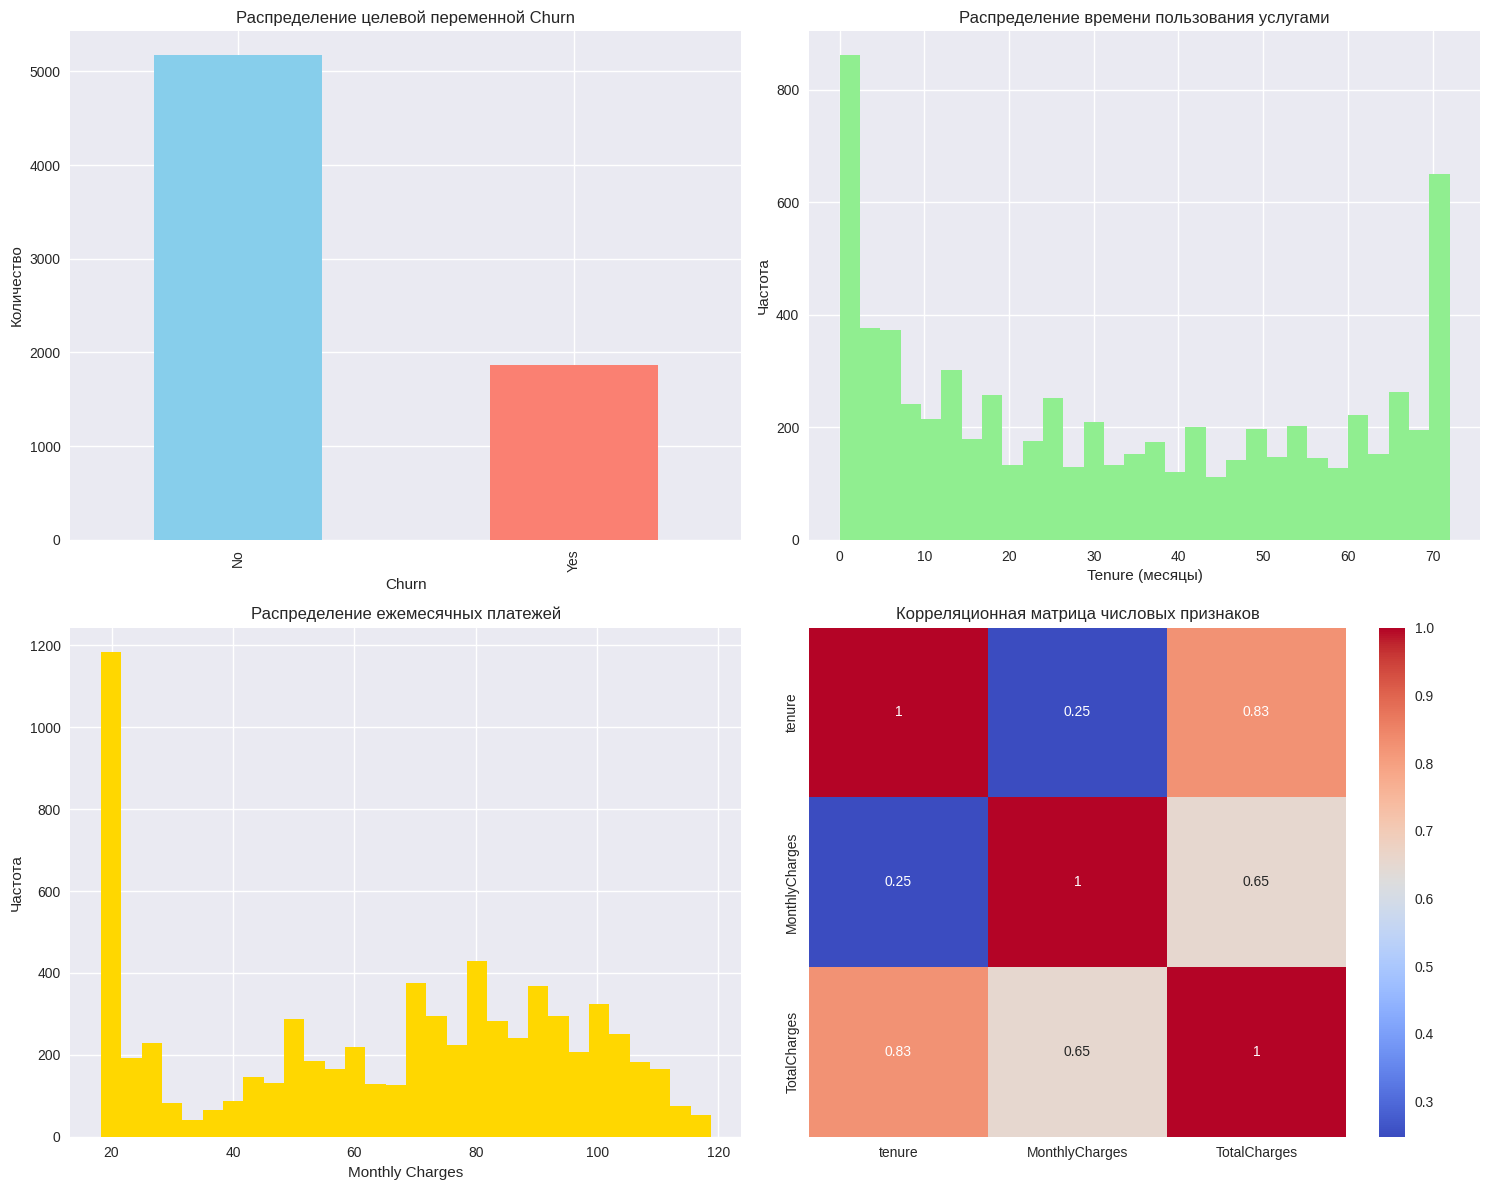

In [6]:
# Настройка стиля графиков
plt.style.use('seaborn-v0_8')
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Распределение целевой переменной
df['Churn'].value_counts().plot(kind='bar', ax=axes[0,0], color=['skyblue', 'salmon'])
axes[0,0].set_title('Распределение целевой переменной Churn')
axes[0,0].set_ylabel('Количество')

# Распределение tenure (время пользования услугами)
df['tenure'].hist(bins=30, ax=axes[0,1], color='lightgreen')
axes[0,1].set_title('Распределение времени пользования услугами')
axes[0,1].set_xlabel('Tenure (месяцы)')
axes[0,1].set_ylabel('Частота')

# Распределение MonthlyCharges
df['MonthlyCharges'].hist(bins=30, ax=axes[1,0], color='gold')
axes[1,0].set_title('Распределение ежемесячных платежей')
axes[1,0].set_xlabel('Monthly Charges')
axes[1,0].set_ylabel('Частота')

# Корреляционная матриза для числовых признаков
numerical_df = df[['tenure', 'MonthlyCharges', 'TotalCharges']]
# Преобразуем TotalCharges в числовой формат
numerical_df['TotalCharges'] = pd.to_numeric(numerical_df['TotalCharges'], errors='coerce')
sns.heatmap(numerical_df.corr(), annot=True, cmap='coolwarm', ax=axes[1,1])
axes[1,1].set_title('Корреляционная матрица числовых признаков')

plt.tight_layout()
plt.show()

In [7]:
print("=== ПРЕДОБРАБОТКА ДАННЫХ ===")

# Обработка TotalCharges - преобразуем в числовой формат и заполняем пропуски
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
print(f"Пропуски в TotalCharges: {df['TotalCharges'].isnull().sum()}")

# Заполняем пропуски медианным значением
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

# Удаляем ненужные столбцы
df = df.drop('customerID', axis=1)

# Кодируем целевую переменную
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# Разделяем признаки и целевую переменную
X = df.drop('Churn', axis=1)
y = df['Churn']

# Кодируем категориальные переменные
categorical_columns = X.select_dtypes(include=['object']).columns
print(f"Категориальные признаки для кодирования: {list(categorical_columns)}")

# Применяем one-hot encoding для категориальных признаков
X_encoded = pd.get_dummies(X, columns=categorical_columns, drop_first=True)

print(f"Размерность после кодирования: {X_encoded.shape}")

=== ПРЕДОБРАБОТКА ДАННЫХ ===
Пропуски в TotalCharges: 11
Категориальные признаки для кодирования: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
Размерность после кодирования: (7043, 30)


In [8]:
# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")

# Масштабирование признаков (важно для SVM и KNN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Масштабирование завершено!")

Размер обучающей выборки: (4930, 30)
Размер тестовой выборки: (2113, 30)
Масштабирование завершено!


In [9]:
# Инициализация моделей
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss'),
    'SVM': SVC(probability=True, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5)
}

# Словари для хранения результатов
results = {}
predictions = {}
probabilities = {}

print("=== ОБУЧЕНИЕ МОДЕЛЕЙ ===")

# Обучение и предсказание для каждой модели
for name, model in models.items():
    print(f"Обучение {name}...")

    # Выбираем масштабированные данные для SVM и KNN
    if name in ['SVM', 'KNN']:
        X_tr = X_train_scaled
        X_te = X_test_scaled
    else:
        X_tr = X_train
        X_te = X_test

    # Обучение модели
    model.fit(X_tr, y_train)

    # Предсказания
    y_pred = model.predict(X_te)
    y_prob = model.predict_proba(X_te)[:, 1] if hasattr(model, 'predict_proba') else None

    predictions[name] = y_pred
    probabilities[name] = y_prob

    # Расчет метрик
    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_prob) if y_prob is not None else None
    }

    print(f"{name} обучен!")

=== ОБУЧЕНИЕ МОДЕЛЕЙ ===
Обучение Random Forest...
Random Forest обучен!
Обучение XGBoost...
XGBoost обучен!
Обучение SVM...
SVM обучен!
Обучение KNN...
KNN обучен!



=== СРАВНЕНИЕ МЕТРИК МОДЕЛЕЙ ===
               Accuracy  Precision  Recall  F1-score  ROC-AUC
Random Forest    0.7889     0.6298  0.4973    0.5558   0.8201
XGBoost          0.7818     0.6042  0.5169    0.5572   0.8164
SVM              0.7937     0.6464  0.4920    0.5587   0.8062
KNN              0.7496     0.5289  0.5223    0.5256   0.7701


<Figure size 1200x800 with 0 Axes>

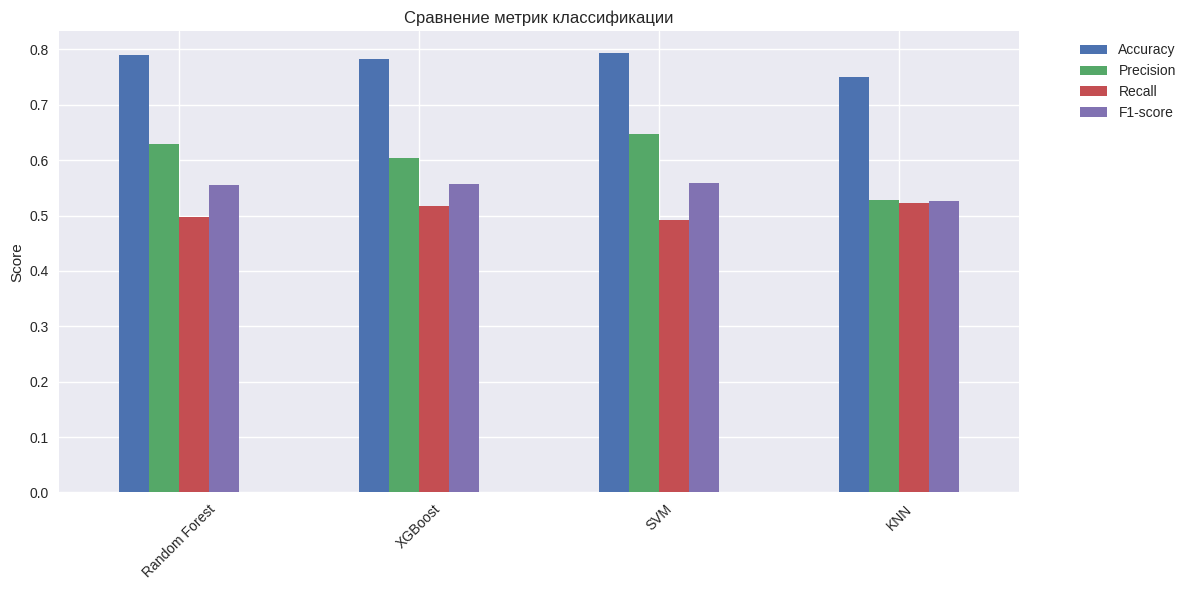

In [10]:
# Создаем DataFrame с результатами
results_df = pd.DataFrame(results).T
print("\n=== СРАВНЕНИЕ МЕТРИК МОДЕЛЕЙ ===")
print(results_df.round(4))

# Визуализация метрик
plt.figure(figsize=(12, 8))
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-score']
results_df[metrics_to_plot].plot(kind='bar', figsize=(12, 6))
plt.title('Сравнение метрик классификации')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

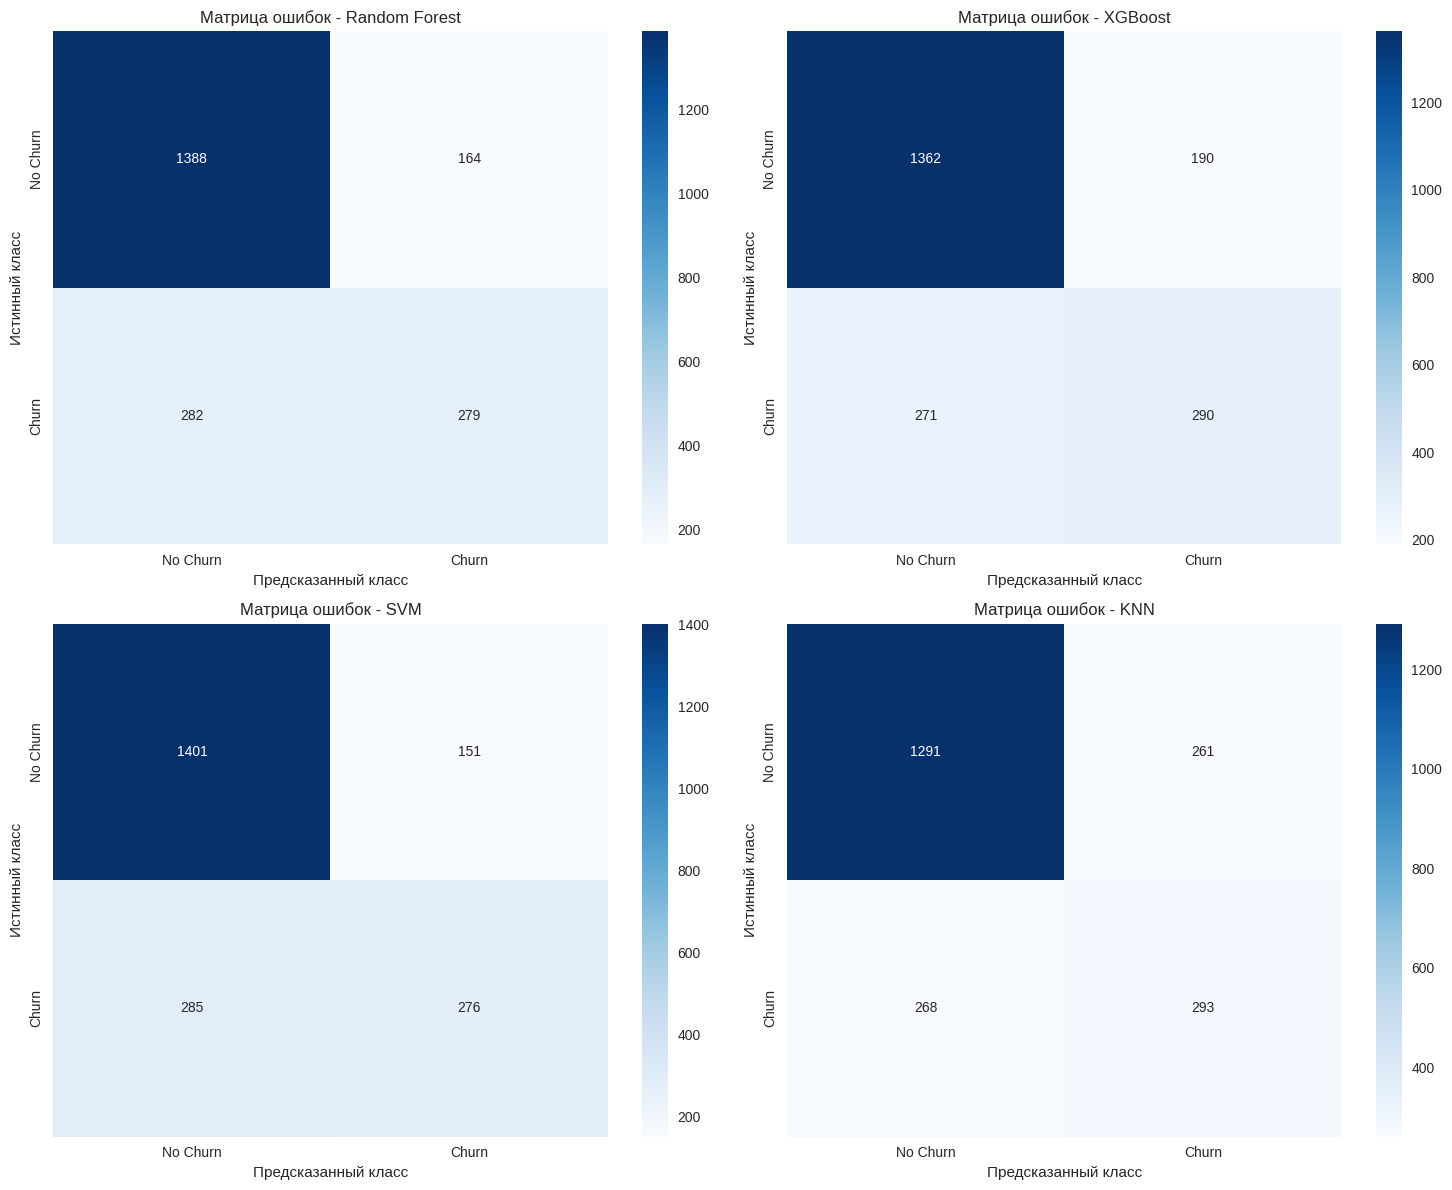

In [11]:
# Построение матриц ошибок
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for idx, (name, y_pred) in enumerate(predictions.items()):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx])
    axes[idx].set_title(f'Матрица ошибок - {name}')
    axes[idx].set_xlabel('Предсказанный класс')
    axes[idx].set_ylabel('Истинный класс')
    axes[idx].set_xticklabels(['No Churn', 'Churn'])
    axes[idx].set_yticklabels(['No Churn', 'Churn'])

plt.tight_layout()
plt.show()

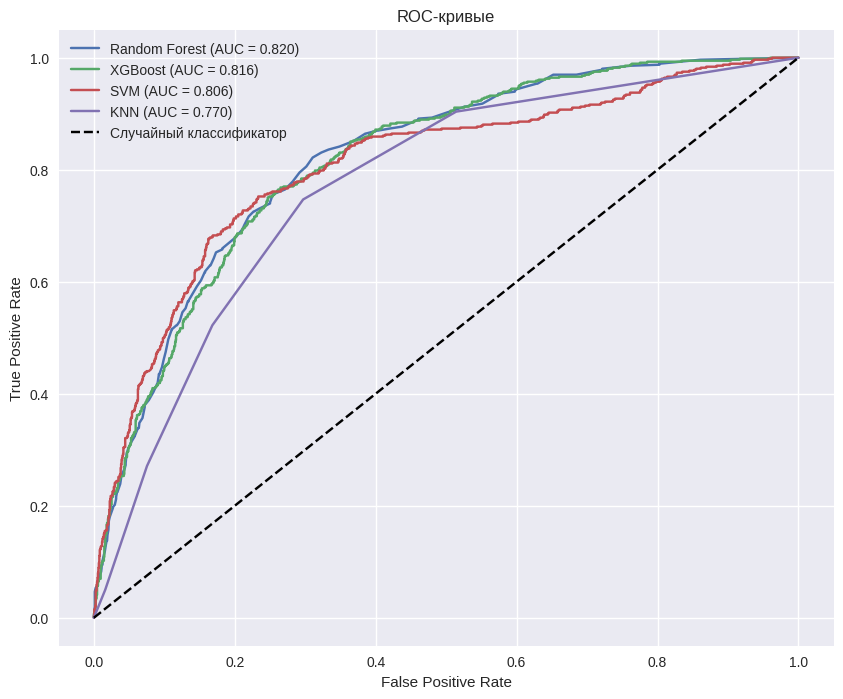

In [12]:
# Построение ROC-кривых
plt.figure(figsize=(10, 8))

for name, y_prob in probabilities.items():
    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        auc_score = roc_auc_score(y_test, y_prob)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Случайный классификатор')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривые')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
print("=== ВЫВОДЫ ===")

# Находим лучшую модель по F1-score (баланс между Precision и Recall)
best_model = results_df['F1-score'].idxmax()
print(f"Лучшая модель по F1-score: {best_model}")
print(f"Метрики лучшей модели:")
print(results_df.loc[best_model])

print("\n=== АНАЛИЗ РЕЗУЛЬТАТОВ ===")
print("1. Accuracy показывает общую точность, но может быть misleading при несбалансированных данных")
print("2. Precision - доля правильно предсказанных положительных классов среди всех предсказанных положительных")
print("3. Recall - доля правильно предсказанных положительных классов среди всех истинно положительных")
print("4. F1-score - гармоническое среднее между Precision и Recall")
print("5. ROC-AUC показывает способность модели разделять классы")

print(f"\nДля задачи прогнозирования оттока клиентов важны:")
print("- Высокий Recall: чтобы найти как можно больше реально уходящих клиентов")
print("- Хороший Precision: чтобы минимизировать ложные срабатывания")
print("- Поэтому F1-score является хорошим балансирующим показателем")

=== ВЫВОДЫ ===
Лучшая модель по F1-score: SVM
Метрики лучшей модели:
Accuracy     0.793658
Precision    0.646370
Recall       0.491979
F1-score     0.558704
ROC-AUC      0.806248
Name: SVM, dtype: float64

=== АНАЛИЗ РЕЗУЛЬТАТОВ ===
1. Accuracy показывает общую точность, но может быть misleading при несбалансированных данных
2. Precision - доля правильно предсказанных положительных классов среди всех предсказанных положительных
3. Recall - доля правильно предсказанных положительных классов среди всех истинно положительных
4. F1-score - гармоническое среднее между Precision и Recall
5. ROC-AUC показывает способность модели разделять классы

Для задачи прогнозирования оттока клиентов важны:
- Высокий Recall: чтобы найти как можно больше реально уходящих клиентов
- Хороший Precision: чтобы минимизировать ложные срабатывания
- Поэтому F1-score является хорошим балансирующим показателем


In [14]:
print("""
=== ОТВЕТЫ НА КОНТРОЛЬНЫЕ ВОПРОСЫ ===

1. Что такое EDA и зачем его проводить?
EDA (Exploratory Data Analysis) - это исследовательский анализ данных, который включает
визуализацию, статистический анализ и изучение закономерностей. Проводится для понимания
структуры данных, выявления аномалий, пропусков и взаимосвязей между переменными.

2. Как закодировать категориальные признаки?
- One-Hot Encoding: создает бинарные признаки для каждой категории (подходит для большинства моделей)
- Label Encoding: присваивает числовые метки (подходит для деревьев)
- Target Encoding: заменяет категории средним значением целевой переменной

3. Чем отличается Decision Tree от Random Forest?
Decision Tree - одно дерево решений, склонное к переобучению.
Random Forest - ансамбль многих деревьев, каждое обучается на случайном подмножестве данных,
что уменьшает переобучение и повышает обобщающую способность.

4. В чём идея метода k-ближайших соседей (KNN)?
Объект классифицируется на основе классов его k ближайших соседей в пространстве признаков.
Простой интуитивный метод, но требует масштабирования и может быть медленным на больших данных.

5. Что делает метод опорных векторов (SVM)?
Ищет оптимальную разделяющую гиперплоскость с максимальным зазором между классами.
Эффективен в высокомерных пространствах, но требует масштабирования данных.

6. Почему важно смотреть не только на Accuracy?
Accuracy может вводить в заблуждение при несбалансированных классах. Например, если 95%
клиентов не уходят, модель, всегда предсказывающая "не уйдет", будет иметь accuracy 95%,
но бесполезна для выявления уходящих клиентов.

7. Что показывает матрица ошибок?
Показывает распределение предсказаний по четырем категориям:
- True Positive (TP): правильно предсказанные положительные
- True Negative (TN): правильно предсказанные отрицательные
- False Positive (FP): ложно предсказанные положительные
- False Negative (FN): ложно предсказанные отрицательные
""")


=== ОТВЕТЫ НА КОНТРОЛЬНЫЕ ВОПРОСЫ ===

1. Что такое EDA и зачем его проводить?
EDA (Exploratory Data Analysis) - это исследовательский анализ данных, который включает
визуализацию, статистический анализ и изучение закономерностей. Проводится для понимания
структуры данных, выявления аномалий, пропусков и взаимосвязей между переменными.

2. Как закодировать категориальные признаки?
- One-Hot Encoding: создает бинарные признаки для каждой категории (подходит для большинства моделей)
- Label Encoding: присваивает числовые метки (подходит для деревьев)
- Target Encoding: заменяет категории средним значением целевой переменной

3. Чем отличается Decision Tree от Random Forest?
Decision Tree - одно дерево решений, склонное к переобучению.
Random Forest - ансамбль многих деревьев, каждое обучается на случайном подмножестве данных,
что уменьшает переобучение и повышает обобщающую способность.

4. В чём идея метода k-ближайших соседей (KNN)?
Объект классифицируется на основе классов его k ближ